In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import glob 
import os
from scipy.stats import rankdata
from scipy.signal import savgol_filter
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# 忽略特定类型的警告
warnings.filterwarnings("ignore")

#### 相关函数定义

In [21]:
# 获取路径下的文件函数============================
def get_file_list(file_path):
    '''
    file_path:str        # 文件夹路径
    return:list          # 返回对应文件夹下所有对应格式组成的路径列表
    '''
    file_list = glob.glob(os.path.join(file_path,'*csv'))
    
    return file_list


# 动作奖励映射函数===========================================================
def set_ActionReward_mapping(df,stage_index):
    '''
    根据小鼠的动作进行奖励编码,并将小鼠的行为choise进行分类标志
    '''
    # R = 0

    if df.loc[stage_index,'outcome'] == 1:   # CP_noReward
        R = 0
        lickSig = 1    # 选择标志位
    elif df.loc[stage_index,'outcome'] == 2:   # CP_reward
        R = 1
        lickSig = 1
    elif df.loc[stage_index,'outcome'] == 3:   # CG_noReward
        R = 0
        lickSig = 2
    elif df.loc[stage_index,'outcome'] == 4:   # CG_Reward
        R = 1
        lickSig = 2

    return R,lickSig

def get_Q_list_TD0(df_go):
    '''
    df: dataframe 传入数据行为每一次试验,column0:每次试验所给的信号,column1:为每次输出的结果或者动作.
    N_STATES: 所切换的状态的总数,如试验的总次数.
    ALPHA: float 取值为0~1,学习率
    GAMMA: float 取值为0~1,折扣率
    stage_name: 获取Q值的阶段,如stable,uncertain,reverse
    return Q_go,Q_nogo: 返回单步更新的 Q_go,Q_nogo 值
    # 算法原理（贝尔曼方程）
    # Q(s, a) = Q(s, a) + α(r + γ * Q(s', a') - Q(s, a))
    '''
    # 迭代超参数设置
    THETA = 0.08
    THETA_p = 0.6
    PE = 0
    # 初始化迭代初值
    Q_CP = 0
    Q_CG = 0
    # 超参数设置
    ALPHA = 0.1
    # GAMMA = 0.1

    Q = []                         # 创建存储迭代过程的go_Q值空列表
    alpha_list = []                   # 创建存储迭代过程的alpha值空列表
    pre_err = []                      # 创建存储迭代过程的PE值空列表

    Q.append([Q_CP,Q_CG])
    alpha_list.append(ALPHA)
    pre_err.append(PE)

    go_N_STATES = np.array(df_go).shape[0]

    for i in range(go_N_STATES-1):
    # for i in range(go_N_STATES):
        
        R,lickSig = set_ActionReward_mapping(df_go,i)
        if lickSig ==1:
            PE= R - Q_CP
            ALPHA = THETA_p*ALPHA+THETA*abs(PE)
            Q_CP = Q_CP + ALPHA*(R - Q_CP)
            
        else:
            PE = R - Q_CG
            ALPHA = THETA_p*ALPHA+THETA*abs(PE)
            Q_CG = Q_CG + ALPHA*(R - Q_CG)


        alpha_list.append(ALPHA)
        pre_err.append(PE)
        Q.append([Q_CP,Q_CG])

    return Q,alpha_list,pre_err


def get_Q_list_SARSA(df_go):
    '''
    df: dataframe 传入数据行为每一次试验,column0:每次试验所给的信号,column1:为每次输出的结果或者动作.
    N_STATES: 所切换的状态的总数,如试验的总次数.
    ALPHA: float 取值为0~1,学习率
    GAMMA: float 取值为0~1,折扣率
    stage_name: 获取Q值的阶段,如stable,uncertain,reverse
    return Q_go,Q_nogo: 返回单步更新的 Q_go,Q_nogo 值
    # 算法原理（贝尔曼方程）
    # Q(s, a) = Q(s, a) + α(r + γ * Q(s', a') - Q(s, a))
    '''

    Q = []                         # 创建存储迭代过程的go_Q值空列表

    # 初始化迭代初值
    Q_CP = 0
    Q_CG = 0

    ALPHA = 0.1
    GAMMA = 0

    Q.append([Q_CP,Q_CG])
    go_N_STATES = np.array(df_go).shape[0]

    for i in range(go_N_STATES-1):
        
        R,lickSig = set_ActionReward_mapping(df_go,i)
        next_R,next_lickSig = set_ActionReward_mapping(df_go,i+1)
        
        if lickSig ==1:
            Q_CP = Q_CP + ALPHA*(R + GAMMA * next_R - Q_CP)
        else:
            Q_CG = Q_CG + ALPHA*(R + GAMMA * next_R - Q_CG)

        # Qs_go = Qs_go + ALPHA*(R + GAMMA * Qs_go_next_R - Qs_go)

        Q.append([Q_CP,Q_CG])

    return Q


# QP转换相关函数===============================================================
# ==========动态融合策略 and softmax======
# 定义带有水平偏移参数的递减Sigmoid函数
def shifted_decreasing_sigmoid(x, steepness, x_offset):
    return 1 - 1 / (1 + np.exp(-(x - x_offset) * steepness))


def softmax_update(Q,Scale_Factor):

    scale_factor=Scale_Factor
    
    e_Q = np.exp(scale_factor * (Q - np.max(Q)))
    P = e_Q / e_Q.sum(axis=1, keepdims=True)

    return P


# 仿真序列生成模型==============================================================
def get_genAction(df,iter_num): 
    '''
    可以实现探索利用动态调整策略和softmax决策策略
    '''

    stimu_df_list = []

    for iter_i in range(iter_num):
        # 随机选择动作序列和计算奖励
        # np.random.seed(400)  # 设置随机种子以确保结果可重复
        action_sequence = []
        stim_outcome = []  # 对选择进行编码
        motivation = [] # 对选择动机进行编码

        # 随机选择动作序列和计算奖励
        # print(result_df)
        for _, row in df.iterrows():
            p_cp = row['P_CP']
            p_cg = row['P_CG']
            
            # ε 策略
            if np.random.rand() < row['epsilon']:
                # 随机选择CP、CG或Miss动作
                choice = np.random.choice(['CP', 'CG'], p=[1/2, 1/2])

            else:
                # 根据概率值选择CP或CG动作
                choice = np.random.choice(['CP', 'CG'], p=[p_cp, p_cg])
            
            if choice == 'CP':
                st_outcome = 1  
                motiv = 1
            elif choice == 'CG':
                st_outcome = 2  # CP选择的奖励值为+1
                motiv = -1
            
            action_sequence.append(choice)
            stim_outcome.append(st_outcome)
            motivation.append(motiv)
        
        # 创建一个新的DataFrame来存储这些变量的值
        stimu_df = pd.DataFrame({'action_sequence': action_sequence, 'stim_outcome': stim_outcome, 'motivation': motivation})
        stimu_df['iter_num'] = iter_i+1
        stimu_df_list.append(stimu_df)

    return stimu_df_list


def get_genAction_epsilon_greed(df,iter_num,epsilon): 
    '''
    可以实现epsilon_greed决策策略
    '''
    stimu_df_list = []

    for iter_i in range(iter_num):

        # 随机选择动作序列和计算奖励
        # np.random.seed(400)  # 设置随机种子以确保结果可重复
        action_sequence = []
        stim_outcome = []  # 对选择进行编码
        motivation = [] # 对选择动机进行编码

        for _, row in df.iterrows():
            
            q_cp = row['Q_CP']
            q_cg = row['Q_CG']
            # ε 策略
            if np.random.rand() < epsilon:
                # 随机选择CP、CG或Miss动作
                choice = np.random.choice(['CP', 'CG'], p=[1/2, 1/2])
            else:
                # 根据概率值选择CP或CG动作
                if q_cp > q_cg:
                    choice = np.random.choice(['CP', 'CG'], p=[1, 0])
                elif q_cp <= q_cg:
                    choice = np.random.choice(['CP', 'CG'], p=[0, 1])
            
            if choice == 'CP':
                st_outcome = 1  
                motiv = 1
            elif choice == 'CG':
                st_outcome = 2  # CP选择的奖励值为+1
                motiv = -1
            
            action_sequence.append(choice)
            stim_outcome.append(st_outcome)
            motivation.append(motiv)
        
        # 创建一个新的DataFrame来存储这些变量的值
        stimu_df = pd.DataFrame({'action_sequence': action_sequence, 'stim_outcome': stim_outcome, 'motivation': motivation})
        stimu_df['iter_num'] = iter_i+1
        stimu_df_list.append(stimu_df)

    return stimu_df_list


def get_genAction_sf(df,iter_num): 
    '''
    可以实现探索利用动态调整策略和softmax决策策略
    '''

    stimu_df_list = []

    for iter_i in range(iter_num):
        # 随机选择动作序列和计算奖励
        # np.random.seed(400)  # 设置随机种子以确保结果可重复
        action_sequence = []
        stim_outcome = []  # 对选择进行编码
        motivation = [] # 对选择动机进行编码

        # 随机选择动作序列和计算奖励
        # print(result_df)
        for _, row in df.iterrows():
            p_cp = row['P_CP_sf']
            p_cg = row['P_CG_sf']
            
            choice = np.random.choice(['CP', 'CG'], p=[p_cp, p_cg])
            
            if choice == 'CP':
                st_outcome = 1  
                motiv = 1
            elif choice == 'CG':
                st_outcome = 2  # CP选择的奖励值为+1
                motiv = -1
            
            action_sequence.append(choice)
            stim_outcome.append(st_outcome)
            motivation.append(motiv)
        
        # 创建一个新的DataFrame来存储这些变量的值
        stimu_df = pd.DataFrame({'action_sequence': action_sequence, 'stim_outcome': stim_outcome, 'motivation': motivation})
        stimu_df['iter_num'] = iter_i+1
        stimu_df_list.append(stimu_df)

    return stimu_df_list


# =======================================一致性分析=====================================
# ====================================一致性指标计算函数=================================
def get_person_factor(sequence_1,sequence_2):
    sequence_x = sequence_1
    sequence_y = sequence_2
    # 计算均值
    mean_x = np.mean(sequence_x)
    mean_y = np.mean(sequence_y)
    # 计算皮尔逊相关系数
    numerator = np.sum((sequence_x - mean_x) * (sequence_y - mean_y))
    denominator_x = np.sqrt(np.sum((sequence_x - mean_x) ** 2))
    denominator_y = np.sqrt(np.sum((sequence_y - mean_y) ** 2))
    correlation_coefficient = numerator / (denominator_x * denominator_y)

    return correlation_coefficient


def spearman_rank_correlation(x, y):
    """
    计算两个序列的斯皮尔曼秩相关系数
    参数:
    x, y (array-like): 两个待比较的序列，可以是NumPy数组、列表或其他可迭代对象。
    返回:
    rho (float): 斯皮尔曼秩相关系数的值，范围在-1到1之间，越接近1表示越强的正相关性，越接近-1表示越强的负相关性。
    """
    # 使用rankdata函数将序列转换为秩
    ranks_x = rankdata(x)
    ranks_y = rankdata(y)
    # 计算秩的差值
    rank_diff = ranks_x - ranks_y
    # 计算斯皮尔曼秩相关系数
    n = len(x)
    rho = 1 - (6 * np.sum(rank_diff**2)) / (n * (n**2 - 1))

    return rho


# 滑动窗口求概率的相关函数=============================
def calculate_probability(sub_df):
    
    total_rows = len(sub_df)
    outcome_1_rows = len(sub_df[(sub_df['outcome'] == 1)|(sub_df['outcome'] == 2)])
    probability = outcome_1_rows / total_rows

    return probability

def calculate_probability_stimu(sub_df): # 用于仿真序列概率求解
    
    total_rows = len(sub_df)
    outcome_1_rows = len(sub_df[(sub_df['stim_outcome'] == 1)])
    probability = outcome_1_rows / total_rows

    return probability

def slide_window_probabilities(df,windowSize,stepSize,mode):
    '''
    滑动窗口计算概率变化
    mode:用于设定计算概率的样本是实验数据还是仿真数据,0为实验数据.其他为仿真数据
    '''
    window_size = windowSize  # 滑动窗口大小
    step_size = stepSize  # 步长

    probabilities = []  # 存储计算得到的概率值

    for i in range(0, len(df) - window_size + 1, step_size):
        sub_df = df.iloc[i:i+window_size]
        if mode == 0:
            probability = calculate_probability(sub_df)
        else:probability = calculate_probability_stimu(sub_df)
        probabilities.append(probability)

    return probabilities


#### 相关数据读入以及写出路径设置

In [22]:
data_read_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\random_reward_propapbility\data_csv\03.csv'
# qp_save_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\random_reward_propapbility\QP_data\01QP.csv'
# stimu_save_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\random_reward_propapbility\simulation_data\05simulation.csv'
# stimu_save_path_sf = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\random_reward_propapbility\simulation_data\05simulation_sf.csv'
# stimu_save_path_eg = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\random_reward_propapbility\simulation_data\05simulation_eg.csv'
# param_save_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\random_reward_propapbility\param_data\05param.csv'

In [23]:
stimu_iterNum = 5000
# 定义可调整的模型参数字典
model_params = {
    
    'steepness': 25,
    'x_offset': 0.5,
    'scale_factor': 2.3,
    'epsilon_greed':0.1
}

In [24]:
# 将所设置的模型参数保存到本地
model_params_df = pd.DataFrame(model_params,index=[0])
# model_params_df.to_csv(param_save_path,index=False)

#### 相关数据的读入

In [25]:
df = pd.read_csv(data_read_path,index_col=0)
df.head(5)
# 创建映射字典,将有奖励和无奖励忽略，只关注选择类别
mapping_dict = {1: 1, 2: 1, 3: 2,4: 2}
df['exp_outcome'] = df['outcome'].map(mapping_dict)

#### Q值估值序列

100    0.623207
101    0.629227
102    0.534645
103    0.566304
104    0.581181
105    0.609674
106    0.535318
107    0.548706
108    0.560756
109    0.571601
110    0.581361
111    0.590146
112    0.598052
113    0.631131
114    0.638246
115    0.644650
116    0.650414
117    0.655601
118    0.660269
119    0.664470
120    0.668252
121    0.671655
122    0.674718
123    0.577475
124    0.507246
Name: Q_PE, dtype: float64


,Q_CP,Q_CG
0,0.005403,0.010216
1,0.012588,0.027259
2,0.025114,0.048318
3,0.042585,0.072262
4,0.064602,0.097960


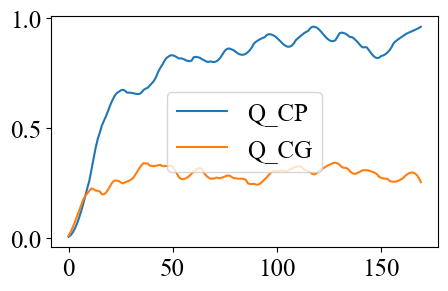

In [26]:
Q_list = get_Q_list_SARSA(df)
df_Q = pd.DataFrame(Q_list,columns=['Q_CP','Q_CG'])
# print(Q_list)
df = pd.concat([df,df_Q],axis=1)
df['Q_PE'] = df['Q_PE'] =abs(df['Q_CP'] - df['Q_CG'])
# print(df['Q_PE'].max())
# print(df['Q_PE'].mean())
print(df['Q_PE'][100:125])
# 根据Q值的差异计算每一步的探索率
steepness = model_params['steepness']  # 递减速度参数
x_offset = model_params['x_offset']  # 水平偏移参数
df['epsilon'] = shifted_decreasing_sigmoid(df['Q_PE'], steepness, x_offset)

smoothed_Q_CP = savgol_filter(df['Q_CP'], window_length=15, polyorder=3) # Savitzky-Golay 滤波
smoothed_Q_CG = savgol_filter(df['Q_CG'], window_length=15, polyorder=3)
df['Q_CP'] = smoothed_Q_CP
df['Q_CG'] = smoothed_Q_CG

df[['Q_CP','Q_CG']].plot(figsize=(5,3))

# 使用平滑后的结果进行仿真分析
df_Q1 = df[['Q_CP','Q_CG']]
df_Q1.head(5)

#### QP转化策略

In [27]:
# =====最优Decision-Function====
probabilities = softmax_update(np.array(df_Q1), model_params['scale_factor'])
# print(probabilities)
df['P_CP'] = 0.5*df['epsilon']+(1-df['epsilon'])*probabilities[:,0]
df['P_CG'] = 0.5*df['epsilon']+(1-df['epsilon'])*probabilities[:,1]

# =====softmax_function=========
probabilities_sf = softmax_update(np.array(df_Q1), model_params['scale_factor'])
df['P_CP_sf'] = probabilities[:,0]
df['P_CG_sf'] = probabilities[:,1]

# ======eplsion_greed 直接作用于动作生成函数============

# df[['P_CP','P_CG']].plot(figsize=(5,3))
# df[['P_CP_sf','P_CG_sf']].plot(figsize=(5,3))

# 根据条件更新 motivation 列
df.loc[df['outcome'].isin([1, 2]), 'motivation'] = 1
df.loc[df['outcome'].isin([3, 4]), 'motivation'] = -1

# 将基于真实决策序列的QP值保存到本地
# df.to_csv(qp_save_path)

#### 仿真序列

In [28]:
# MCMC 重复采样，获取足够的决策序列
stimu_df_list = get_genAction(df,stimu_iterNum)
stimu_df_list_eg = get_genAction_epsilon_greed(df,stimu_iterNum,model_params['epsilon_greed'])
stimu_df_list_sf = get_genAction_sf(df,stimu_iterNum)

# 将生成的数据保存到本地
stimu_df_totol = pd.concat([df_stim for df_stim in stimu_df_list], axis=0)
stimu_df_totol_eg = pd.concat([df_stim for df_stim in stimu_df_list_eg], axis=0)
stimu_df_totol_sf = pd.concat([df_stim for df_stim in stimu_df_list_sf], axis=0)
# stimu_df_totol.to_csv(stimu_save_path)
# stimu_df_totol_eg.to_csv(stimu_save_path_eg)
# stimu_df_totol_sf.to_csv(stimu_save_path_sf)

#### 一致性分析

In [29]:
def getStimu_motiv_MeanAndStd(stimu_df_List):

    motivation_concatenated = pd.concat([np.cumsum(df_stim['motivation']) for df_stim in stimu_df_List], axis=1)

    # 计算每行的均值和标准差
    mean_motivation_series = motivation_concatenated.mean(axis=1)
    std_values = motivation_concatenated.std(axis=1)

    motivation_lower = mean_motivation_series-1.96*std_values
    motivation_upper = mean_motivation_series+1.96*std_values

    return mean_motivation_series,motivation_lower,motivation_upper
# 实验决策序列的决策倾向累计变化趋势
cumul_motiv_df = np.cumsum(df['motivation'])

# 计算仿真数据的决策倾向性累计均值和方差    三种仿真方式
mean_motivation_series,motivation_lower,motivation_upper = getStimu_motiv_MeanAndStd(stimu_df_list)
mean_motivation_series_eg,motivation_lower_eg,motivation_upper_eg = getStimu_motiv_MeanAndStd(stimu_df_list_eg)
mean_motivation_series_sf,motivation_lower_sf,motivation_upper_sf = getStimu_motiv_MeanAndStd(stimu_df_list_sf)

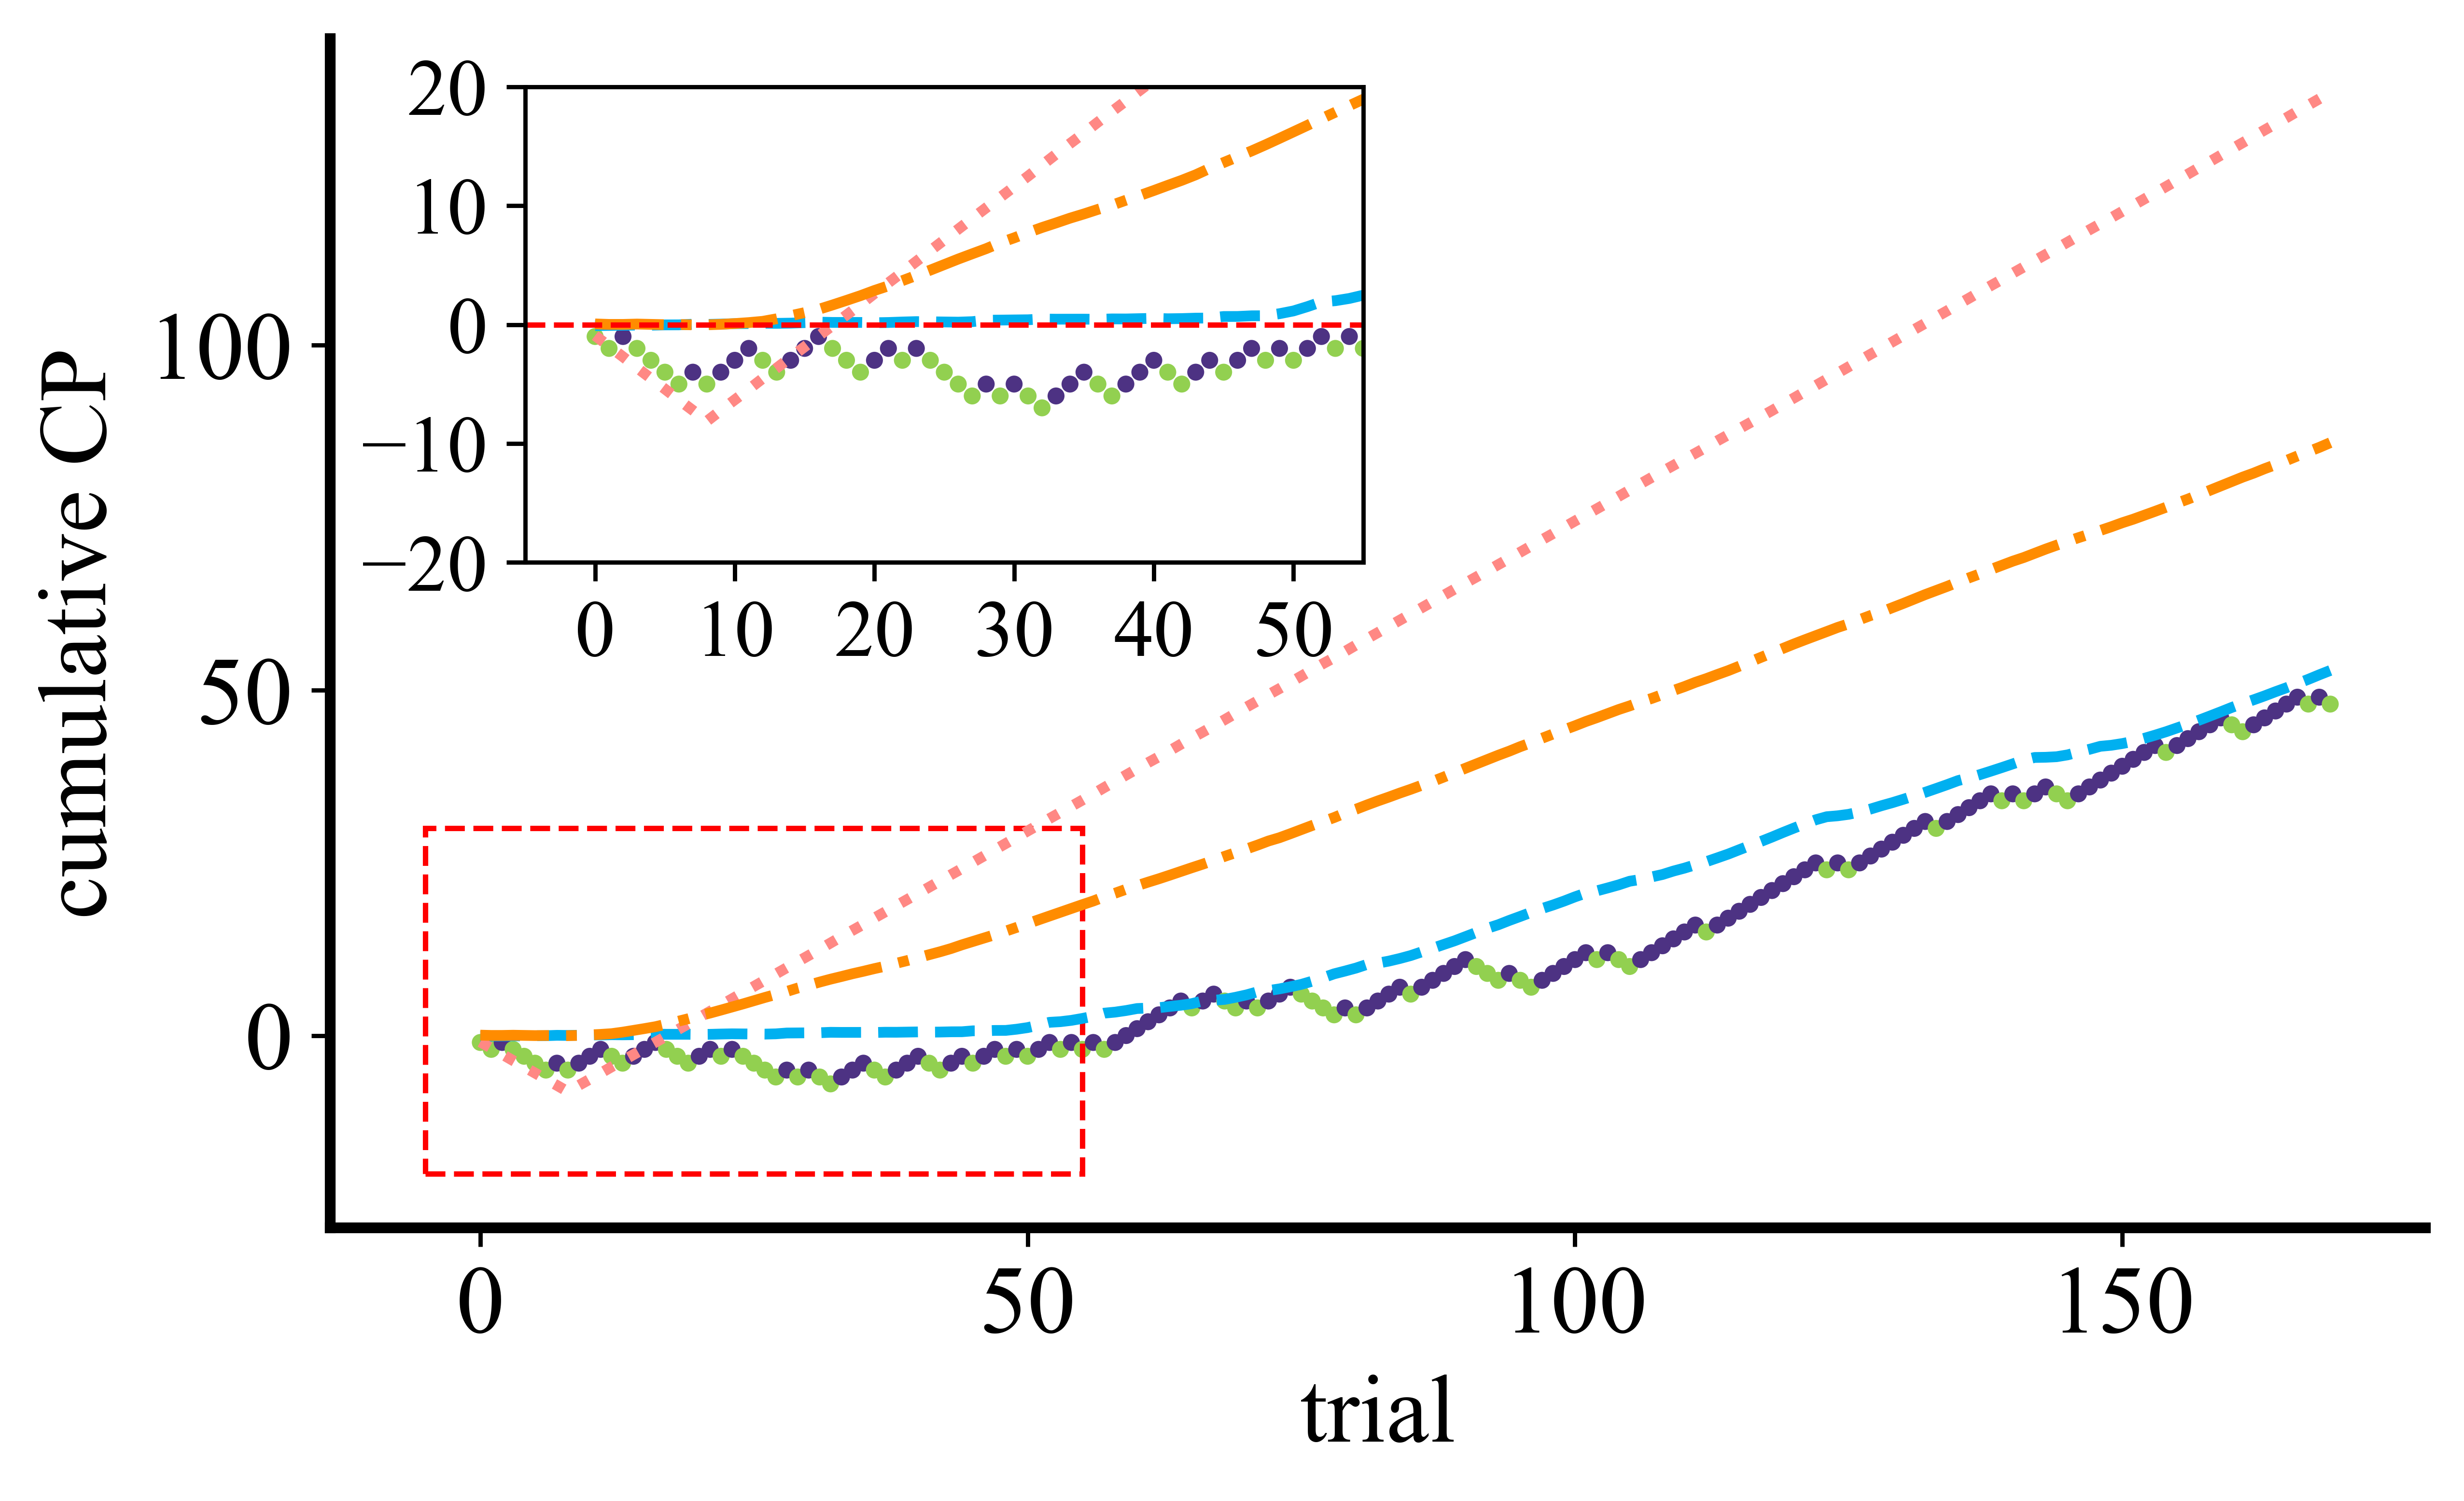

In [37]:
plt.figure(figsize=(7, 4), dpi=800)

# 设置字体为新罗马字体和大小
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

colors = {1: '#4D3283', 2: '#4D3283', 3: '#92D050', 4: '#92D050'}

# 这里假设df和cumul_motiv_df等变量已经定义
for i, action in enumerate(df['outcome']):
    plt.scatter(i, cumul_motiv_df[i], marker='o', edgecolor='none', facecolor=colors[action], s=10, label='experiment' if i == 2 else "")


plt.plot(range(len(mean_motivation_series)), mean_motivation_series, linestyle='--', c='#00B0F0', linewidth=2, alpha=1, label='auto_policy')
plt.plot(range(len(mean_motivation_series_eg)), mean_motivation_series_eg, linestyle=':', c='#FF8884', linewidth=2, alpha=1, label='epsilon greed')
plt.plot(range(len(mean_motivation_series_sf)), mean_motivation_series_sf, linestyle='-.', c='#FF8C00', linewidth=2, alpha=1, label='softmax')
plt.xlabel('trial')
plt.ylabel('cumulative CP')
# plt.legend(loc='upper right', fontsize=15)  # 设置图例的字体大小

# 调整主图边框样式
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['bottom'].set_linewidth(2)

# 定义要突出显示的区域
rect = patches.Rectangle((-5, -20), 60, 50, linewidth=1, linestyle='--', edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

# 创建一个插入的子图区域，调整子图的位置
ax_inset = inset_axes(plt.gca(), width="80%", height="80%", loc=2, bbox_to_anchor=(0.07, 0.5, 0.5, 0.5), bbox_transform=plt.gca().transAxes)
for i, action in enumerate(df['outcome']):
    ax_inset.scatter(i, cumul_motiv_df[i], marker='o', edgecolor='none', facecolor=colors[action], s=10)

ax_inset.plot(range(len(mean_motivation_series)), mean_motivation_series, linestyle='--', c='#00B0F0', linewidth=2, alpha=1)
ax_inset.plot(range(len(mean_motivation_series_eg)), mean_motivation_series_eg, linestyle=':', c='#FF8884', linewidth=2, alpha=1)
ax_inset.plot(range(len(mean_motivation_series_sf)), mean_motivation_series_sf, linestyle='-.', c='#FF8C00', linewidth=2, alpha=1)

ax_inset.set_xlim(-5, 55)
ax_inset.set_ylim(-10, 10)

# 为子图添加坐标轴刻度
ax_inset.set_xticks(range(0, 55, 10))
ax_inset.set_yticks(range(-20, 30, 10))

# 设置子图的坐标轴刻度字体大小
ax_inset.tick_params(axis='both', which='major', labelsize=15)

# 在子图中添加一条 y=0 的红色虚线作为基准线
ax_inset.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.show()


In [31]:
# 概率一致性分析
# 实验数据滑动窗口概率求解
window_size = 35
step_size = 1
real_P = slide_window_probabilities(df,window_size,step_size,0)

def getStimu_slideP(stimu_dflist):

    # 仿真序列滑动窗口概率求解
    stimu_slide_P = []

    for df_sti in stimu_dflist:
        stim_P = slide_window_probabilities(df_sti,window_size,step_size,1)
        stimu_slide_P.append(stim_P)

    stimu_meanP = np.mean(np.array(stimu_slide_P),axis=0)
    stimu_stdP = np.std(np.array(stimu_slide_P),axis=0)
    # 获取每一行最大值和最小值的概率值序列

    slidePmax = stimu_meanP+1.96*stimu_stdP
    # 求取每一行的最小值
    slidePmin = stimu_meanP-1.96*stimu_stdP
    return stimu_meanP, slidePmax, slidePmin

stimu_mean_P,slide_Pmax,slide_Pmin = getStimu_slideP(stimu_df_list)
stimu_mean_P_eg,slide_Pmax_eg,slide_Pmin_eg = getStimu_slideP(stimu_df_list_eg)  #eg
stimu_mean_P_sf,slide_Pmax_sf,slide_Pmin_sf = getStimu_slideP(stimu_df_list_sf)  #sf


In [32]:
# 使用Savitzky-Golay平滑方法，使得滑动窗口的样本概率变化趋于平滑
smoothed_real_P = savgol_filter(real_P, window_length=15, polyorder=3)
# 绘制原始数据和平滑曲线
# plt.plot(range(len(real_P)), real_P, label='raw_data')
# plt.plot(range(len(real_P)), smoothed_real_P, label='Savitzky-Golay')
# # 添加图例
# plt.legend()
# # 显示图形
# plt.show()

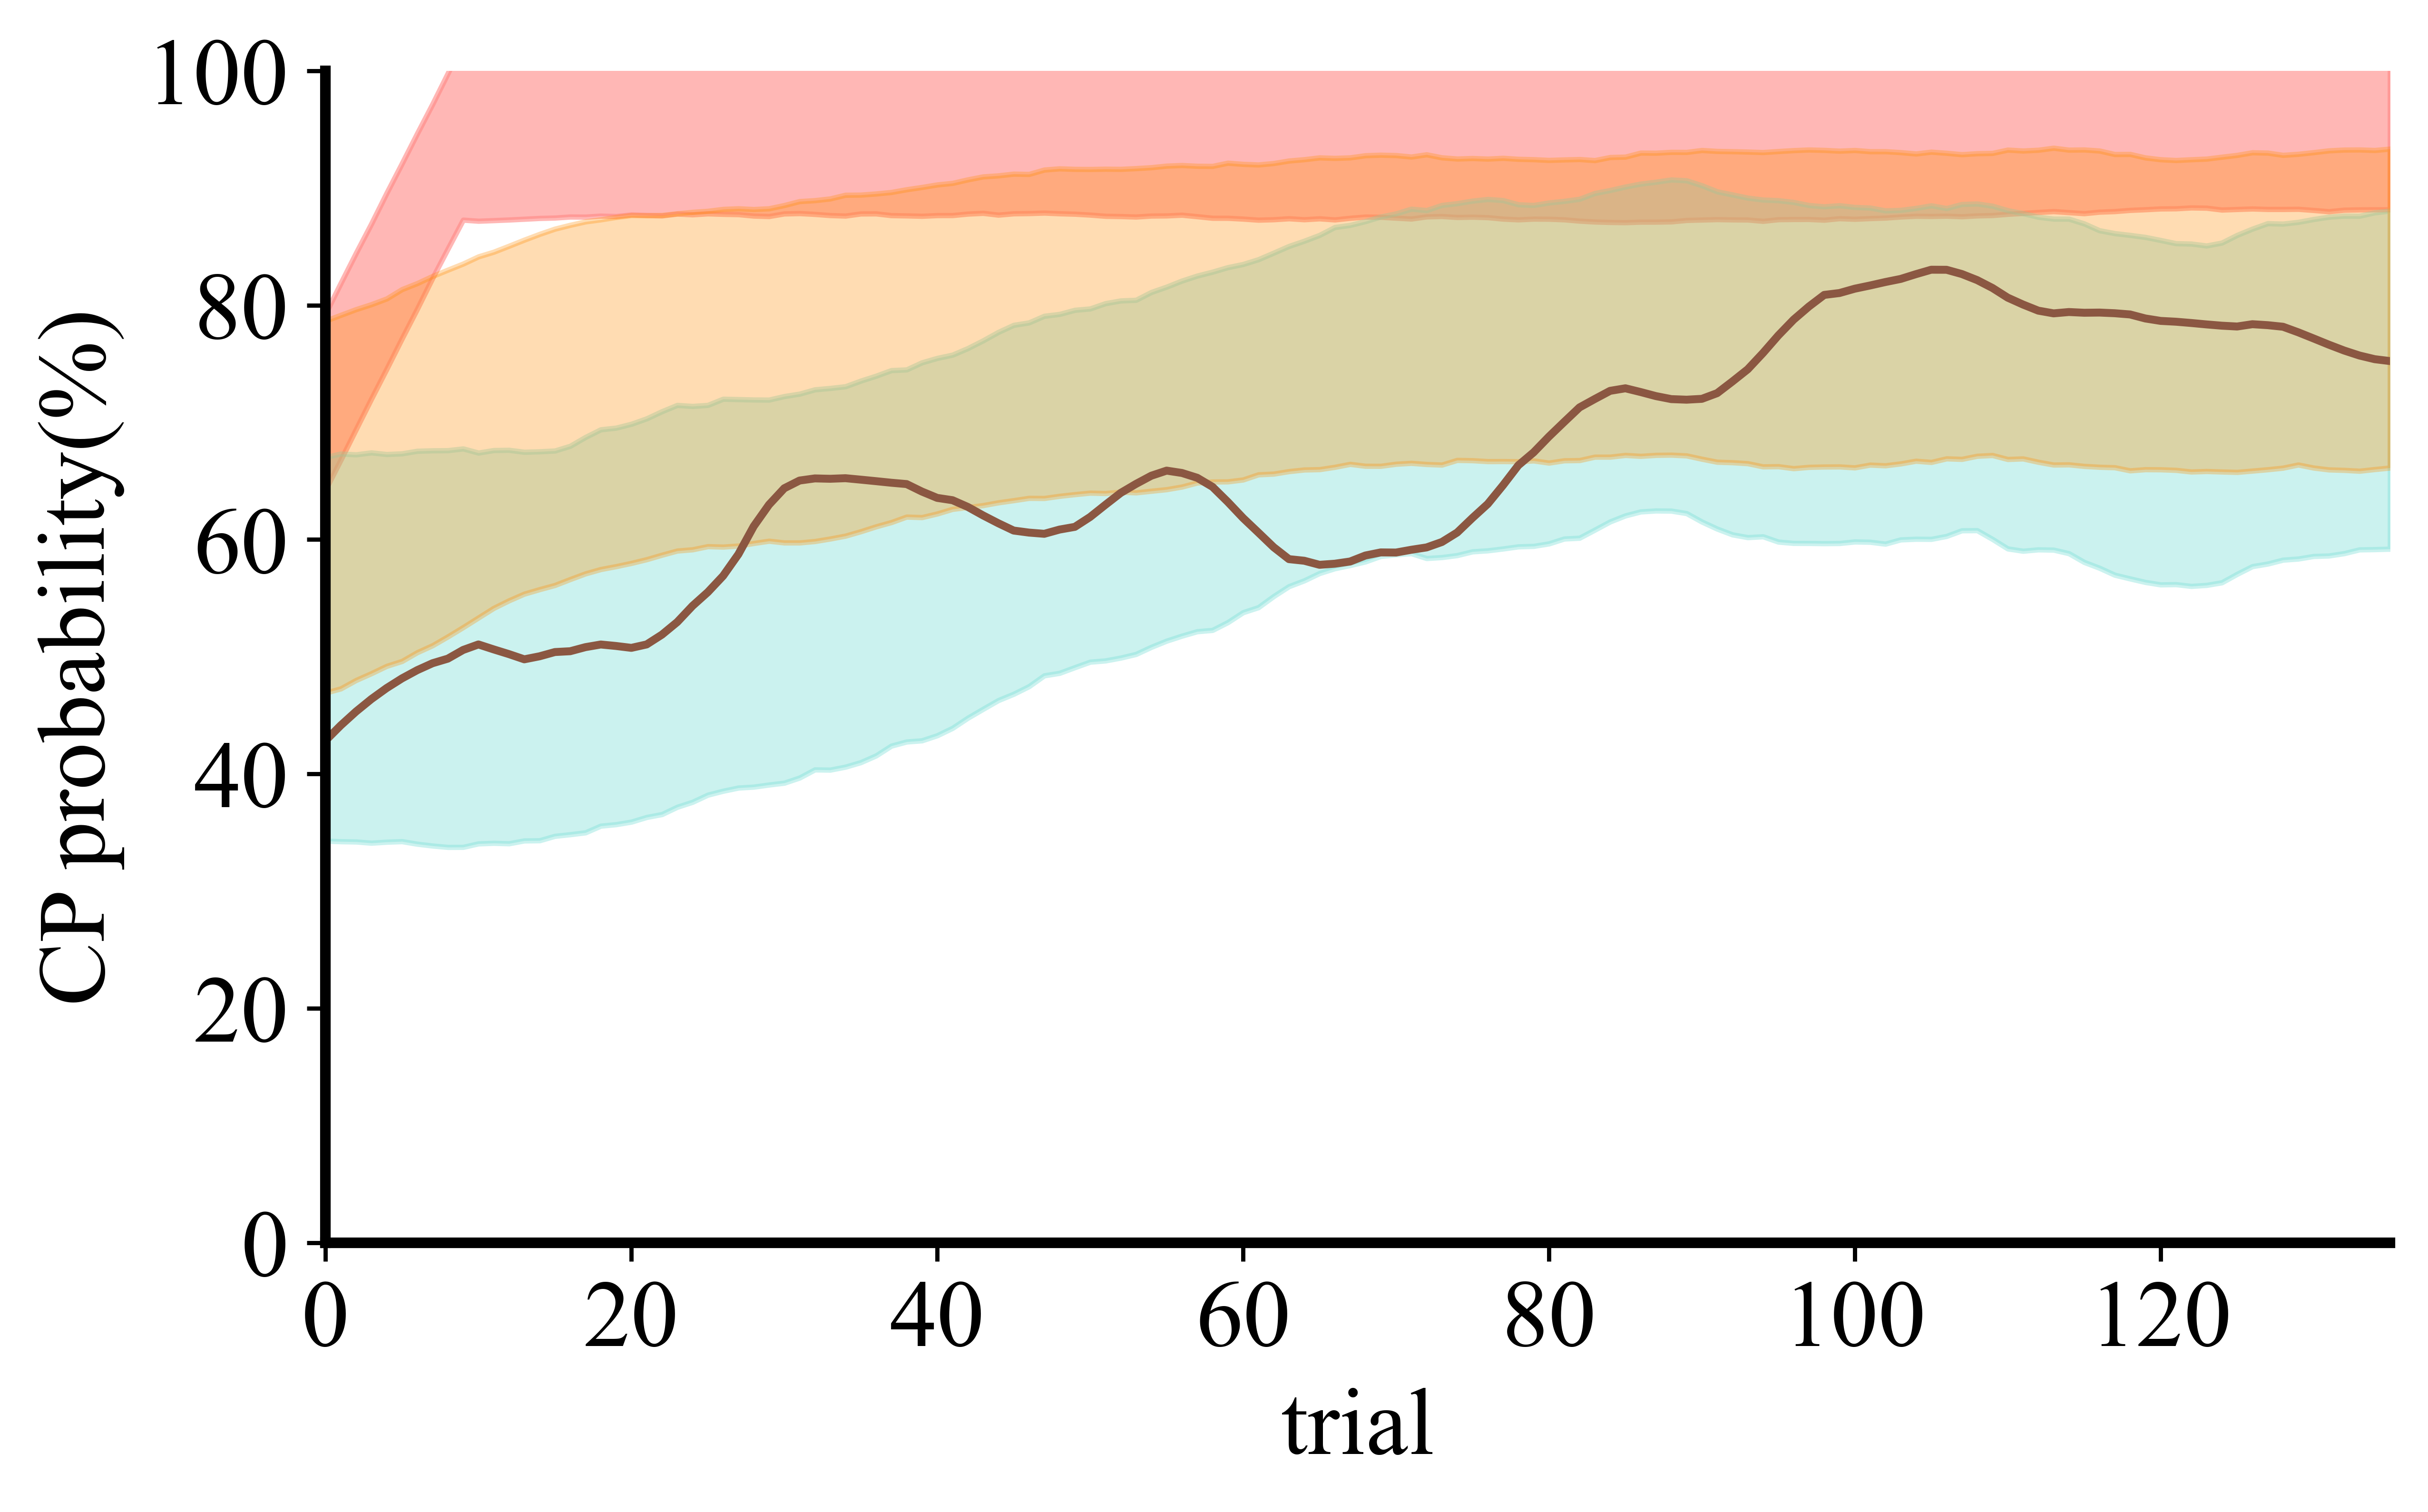

In [33]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(7,4), dpi=800)
# 设置字体为新罗马字体和大小
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

# 绘制填充区域
plt.fill_between(range(len(stimu_mean_P_eg)), slide_Pmin_eg*100, slide_Pmax_eg*100, color='#FF8884', alpha=0.6, label='epsilon greed')  #eg
plt.fill_between(range(len(stimu_mean_P)), slide_Pmin*100, slide_Pmax*100, color='#7DDFD7', alpha=0.4, label='auto policy')
plt.fill_between(range(len(stimu_mean_P_sf)), slide_Pmin_sf*100, slide_Pmax_sf*100, color='#FF8C00', alpha=0.3, label='softmax')  #sf

# 绘制实验和模拟数据线
plt.plot(range(len(real_P)), smoothed_real_P*100, c='#8B5742', label='experiment')
# plt.plot(range(len(stimu_mean_P)), stimu_mean_P, linestyle='-', c='#607B8B', label='simulation', linewidth=2, alpha=0.7)

# 添加标签和标题
plt.xlabel('trial')
plt.xlim(0, len(stimu_mean_P) - 1)

plt.ylabel('CP probability(%)')
# plt.legend(loc='lower right',fontsize=18)

# 设置y轴范围
plt.ylim(0, 100)
# plt.title('probability variation')

# 调整边框样式
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

plt.show()